In [1]:
import numpy as np
import pandas as pd

def generate_data(data_type, n_samples):
    n_samples = n_samples
    
    alpha = 3 
    beta1 = 0.5
    beta2 = 0.6
    beta3 = 0.7
    gamma1 = 2
    gamma2 = 3
    
    # Generate confounders
    X1 = np.random.normal(0, 1, size=n_samples)
    X2 = np.random.normal(0, 1, size=n_samples)
    X3 = np.random.normal(0, 1, size=n_samples)
    
    if data_type == "data1":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta2 * X2 + np.random.normal(loc=0, scale=0.5, size=n_samples)
        
        # Outcome affected by intervention, mediator, confounders, and noise
        Y = alpha +  gamma2* T + gamma1 * M + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data2":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcome affected by intervention, confounders, and noise
        Y = alpha  + gamma2* T + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data3":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta1 * X1 - beta2 * X2 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcomee affected by intervention, mediator, confounders, and noise
        Y = alpha + gamma2* T + gamma1 * M + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})
    
    elif data_type == "data4":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Continuous Outcome influenced by intervention, confounders
        Y = alpha + gamma2 * T + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    else:
        raise ValueError("Unknown data type")

# Use the function in a loop
datasets = {}
for data_name in ["data1", "data2", "data3", "data4"]:
    datasets[data_name] = generate_data(data_name, 1000)

print(datasets["data2"].describe())


       Intervention           X1           X2           X3      Outcome
count   1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean       0.072945     0.039285    -0.043098     0.056684     3.277777
std        1.129431     0.976380     1.026010     1.010051     3.909194
min       -2.966933    -3.263536    -2.907249    -2.935927    -8.012574
25%       -0.689157    -0.622772    -0.735416    -0.654613     0.544598
50%        0.055784     0.058927    -0.100769     0.120415     3.113335
75%        0.796871     0.702324     0.635221     0.713646     5.821561
max        4.099311     3.443985     4.347555     3.328893    18.845722


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

def neural_network_estimate(data):
    # Split data into training and test sets
    X = data.drop(columns='Outcome')
    y = data['Outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a simple neural network model
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Predict on the test set
    y_pred = model.predict(X_test).flatten()

    # Calculate MAPE
    mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))

    return mape


2023-08-14 17:12:52.768130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Number of iterations to obtain 100 sets of coefficients
num_iterations = 100

mape_list = []

# Datasets
data_types = ["data1", "data2", "data3", "data4"]

# Run the estimation multiple times for each data type
for data_type in data_types:
    for i in range(num_iterations):
        # Generate synthetic data
        data = generate_data(data_type, 100000)

        # Estimate using Neural Network and get MAPE
        mape = neural_network_estimate(data)
        
        # Append the MAPE to the list
        mape_list.append(mape)

    # Print the MAPE for all iterations of the current data type
    print(f"Results for {data_type}:")
    for i, mape in enumerate(mape_list):
        print(f"Iteration {i + 1}: MAPE: {mape:.2f}%")
    print("\n")


Epoch 1/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.8665 - val_loss: 1.0356
Epoch 2/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0342 - val_loss: 1.0999
Epoch 3/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0316 - val_loss: 1.1223
Epoch 4/10
2500/2500 [==============================] - 4s 1ms/step - loss: 1.0280 - val_loss: 1.0081
Epoch 5/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0255 - val_loss: 1.0382
Epoch 6/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0201 - val_loss: 1.0024
Epoch 7/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0239 - val_loss: 1.0248
Epoch 8/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0213 - val_loss: 1.0372
Epoch 9/10
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0197 - val_loss: 1.0181
Epoch 10/10
625/625 [==============================] - 1s 728us/step
Epoch 1/10
25

In [11]:
import numpy as np
import pandas as pd

def generate_data(data_type, n_samples):
    n_samples = n_samples
    
    alpha = 3 
    beta1 = 0.5
    beta2 = 0.6
    beta3 = 0.7
    gamma1 = 2
    gamma2 = 3
    
    # Generate confounders
    X1 = np.random.normal(0, 1, size=n_samples)
    X2 = np.random.normal(0, 1, size=n_samples)
    X3 = np.random.normal(0, 1, size=n_samples)
    
    if data_type == "data1":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta2 * X2 + np.random.normal(loc=0, scale=0.5, size=n_samples)
        
        # Outcome affected by intervention, mediator, confounders, and noise
        Y = alpha +  gamma2* T + gamma1 * M + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data2":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcome affected by intervention, confounders, and noise
        Y = alpha  + gamma2* T + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data3":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta1 * X1 - beta2 * X2 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcomee affected by intervention, mediator, confounders, and noise
        Y = alpha + gamma2* T + gamma1 * M + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})
    
    elif data_type == "data4":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Continuous Outcome influenced by intervention, confounders
        Y = alpha + gamma2 * T + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    else:
        raise ValueError("Unknown data type")

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import pandas as pd

def generate_data(data_type, n_samples):
    n_samples = n_samples
    
    alpha = 3 
    beta1 = 0.5
    beta2 = 0.6
    beta3 = 0.7
    gamma1 = 2
    gamma2 = 3
    
    # Generate confounders
    X1 = np.random.normal(0, 1, size=n_samples)
    X2 = np.random.normal(0, 1, size=n_samples)
    X3 = np.random.normal(0, 1, size=n_samples)
    
    if data_type == "data1":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta2 * X2 + np.random.normal(loc=0, scale=0.5, size=n_samples)
        
        # Outcome affected by intervention, mediator, confounders, and noise
        Y = alpha +  gamma2* T + gamma1 * M + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data2":
        # Intervention affected by confounders
        T = beta1 * X1 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcome affected by intervention, confounders, and noise
        Y = alpha  + gamma2* T + beta1* X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    elif data_type == "data3":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Mediator affected by intervention and confounders
        M = gamma1 * T + beta1 * X1 - beta2 * X2 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        # Outcomee affected by intervention, mediator, confounders, and noise
        Y = alpha + gamma2* T + gamma1 * M + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'Mediator': M, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})
    
    elif data_type == "data4":
        # Binary intervention possibly influenced by confounders
        prob_T = 1 / (1 + np.exp(-(X1 + X2)))  # Logistic function
        T = (np.random.rand(n_samples) < prob_T).astype(int)
    
        # Continuous Outcome influenced by intervention, confounders
        Y = alpha + gamma2 * T + beta1 * X1 + beta2 * X2 + beta3 * X3 + np.random.normal(loc=0, scale=1, size=n_samples)
        
        return pd.DataFrame({'Intervention': T, 'X1': X1, 'X2': X2, 'X3': X3, 'Outcome': Y})

    else:
        raise ValueError("Unknown data type")

def prepare_data(df):
    # If the data contains a 'Mediator' column, use it as an additional feature
    if 'Mediator' in df.columns:
        X = df[['Intervention', 'X1', 'X2', 'X3', 'Mediator']].values
    else:
        X = df[['Intervention', 'X1', 'X2', 'X3']].values

    Y0 = df['Outcome'].values
    Y1 = Y0 + 2.0 - 1.0  # Applying the treatment effect and bias as in the previous example
    
    return X, Y0, Y1

# List of data types and sample sizes
data_types = ["data1", "data2", "data3", "data4"]
sample_sizes = [50, 100, 1000]

for data_type in data_types:
    for sample_size in sample_sizes:
        
        # Store treatment effects over the 100 iterations for each scenario
        effects = []

        for i in range(100):
            # Generate data
            df = generate_data(data_type, sample_size)
            X, Y0, Y1 = prepare_data(df)
            
            # Define and compile the CFNN
            input_layer = Input(shape=(X.shape[1],))
            hidden_layer = Dense(64, activation='relu')(input_layer)
            hidden_layer = Dense(64, activation='relu')(hidden_layer)
            output_layer_0 = Dense(1)(hidden_layer)  # Potential outcome for T=0
            output_layer_1 = Dense(1)(hidden_layer)  # Potential outcome for T=1

            model = Model(inputs=input_layer, outputs=[output_layer_0, output_layer_1])
            model.compile(optimizer='adam', loss='mse')

            # Train the CFNN
            model.fit(X, [Y0, Y1], epochs=10, batch_size=32, verbose=0)  # verbose=0 to suppress logs

            # Predict potential outcomes
            Y0_pred, Y1_pred = model.predict(X)

            # Calculate treatment effect
            estimated_treatment_effect = np.mean(Y1_pred - Y0_pred)
            effects.append(estimated_treatment_effect)
            
            mape = np.mean(np.abs(Y1 - ))
        
        print(f"Data Type: {data_type}, Sample Size: {sample_size}")
        print(f"Average Treatment Effect Over 100 Iterations: {np.mean(effects)}\n")


SyntaxError: invalid syntax (3481419957.py, line 116)

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_CFNN(data, data_type):
    # Extract X and Y from the data
    X = data[['X1', 'X2', 'X3']].values
    T = data['Intervention'].values
    Y = data['Outcome'].values

    # If mediator is present in the dataset, extract it
    if 'Mediator' in data.columns:
        M = data['Mediator'].values

    # Define the CFNN model
    input_layer = Input(shape=(X.shape[1],))
    hidden_layer = Dense(128, activation='relu')(input_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)
    hidden_layer = Dense(128, activation='relu')(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dense(64, activation='relu')(hidden_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)

    # Adjusting output layers based on data type
    if data_type in ['data1', 'data3']:
        output_layer_0_Y = Dense(1)(hidden_layer)
        output_layer_1_Y = Dense(1)(hidden_layer)
        output_layer_0_M = Dense(1)(hidden_layer)
        output_layer_1_M = Dense(1)(hidden_layer)
        model = Model(inputs=input_layer, outputs=[output_layer_0_Y, output_layer_1_Y, output_layer_0_M, output_layer_1_M])
    else:
        output_layer_0 = Dense(1)(hidden_layer)
        output_layer_1 = Dense(1)(hidden_layer)
        model = Model(inputs=input_layer, outputs=[output_layer_0, output_layer_1])

    # Using a custom learning rate schedule
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # Early stopping
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

    if data_type in ['data1', 'data3']:
        # Train the CFNN with mediator outputs
        model.fit(X, [Y*(1-T), Y*T, M*(1-T), M*T], epochs=50, batch_size=32, verbose=0, callbacks=[early_stop, reduce_lr])
    else:
        # Train the CFNN without mediator outputs
        model.fit(X, [Y*(1-T), Y*T], epochs=50, batch_size=32, verbose=0, callbacks=[early_stop, reduce_lr])

    # Predict potential outcomes
    outputs = model.predict(X)

    if data_type in ['data1', 'data3']:
        Y0_pred, Y1_pred, M0_pred, M1_pred = outputs
    else:
        Y0_pred, Y1_pred = outputs

    # Calculate the estimated treatment effect
    estimated_treatment_effect = np.mean(Y1_pred - Y0_pred)

    # Calculate MAPE
    mape = np.mean(np.abs((Y - Y0_pred.flatten() * (1-T) - Y1_pred.flatten() * T) / Y))
    rmse = np.sqrt(np.mean(np.square((Y - Y0_pred.flatten()))))

    return mape, rmse, estimated_treatment_effect



2023-08-22 20:47:00.028167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
data_types = ["data1", "data2", "data3", "data4"]
sample_sizes = [100, 500, 1000]

results = []

for data_type in data_types:
    for sample_size in sample_sizes:
        for iteration in range(100):  # Train for 10 iterations
            data = generate_data(data_type, sample_size)
            mape, rmse, causal_effect = train_CFNN(data, data_type)
            
            results.append({
                'Data_Type': data_type,
                'Sample_Size': sample_size,
                'Iteration': iteration + 1,
                'MAPE': mape,
                'RMSE' : rmse, 
                'Causal_Effect': causal_effect, 
                'Method': 'CFNN'
            })

results_df = pd.DataFrame(results)

print(results_df)


32/32 [==============================] - 1s 8ms/step
     Data_Type  Sample_Size  Iteration      MAPE      RMSE  Causal_Effect  \
0        data1          100          1  1.690911  9.949997       4.685291   
1        data1          100          2  1.062272  9.238076       4.200195   
2        data1          100          3  1.893194  8.888567       4.255806   
3        data1          100          4  2.691550  8.025768       3.068989   
4        data1          100          5  1.365801  8.752829       2.804308   
...        ...          ...        ...       ...       ...            ...   
1195     data4         1000         96  0.730367  4.233007       1.970361   
1196     data4         1000         97  0.625229  4.106360       1.703029   
1197     data4         1000         98  0.595919  4.326134       1.667799   
1198     data4         1000         99  0.552532  4.267975       1.983071   
1199     data4         1000        100  0.498408  4.164627       1.866932   

     Method  
0      C

In [13]:
results_df

,Data_Type,Sample_Size,Iteration,MAPE,RMSE,Causal_Effect,Method
0,data1,100,1,1.690911,9.949997,4.685291,CFNN
1,data1,100,2,1.062272,9.238076,4.200195,CFNN
2,data1,100,3,1.893194,8.888567,4.255806,CFNN
3,data1,100,4,2.691550,8.025768,3.068989,CFNN
4,data1,100,5,1.365801,8.752829,2.804308,CFNN
...,...,...,...,...,...,...,...
1195,data4,1000,96,0.730367,4.233007,1.970361,CFNN
1196,data4,1000,97,0.625229,4.106360,1.703029,CFNN
1197,data4,1000,98,0.595919,4.326134,1.667799,CFNN
1198,data4,1000,99,0.552532,4.267975,1.983071,CFNN


In [14]:
results_df.to_csv('results_cfnn.csv', index=False)

In [15]:
import pandas as pd

# Read the CSV into a DataFrame
results_cfnn_df = pd.read_csv('results_cfnn.csv')

# Display the first few rows to check the contents
print(results_cfnn_df.head())


  Data_Type  Sample_Size  Iteration      MAPE      RMSE  Causal_Effect Method
0     data1          100          1  1.690911  9.949997       4.685291   CFNN
1     data1          100          2  1.062272  9.238076       4.200195   CFNN
2     data1          100          3  1.893194  8.888567       4.255806   CFNN
3     data1          100          4  2.691550  8.025768       3.068989   CFNN
4     data1          100          5  1.365801  8.752829       2.804308   CFNN


In [16]:
import numpy as np
# Convert None values to NaN for correct aggregation
results_cfnn_df = results_cfnn_df.where(pd.notna(results_cfnn_df), np.nan)

# Custom aggregation function
def custom_mean(series):
    return np.nan if series.isna().any() else series.mean()

# Group by 'Data_Type' and 'Sample_Size' and calculate custom mean for other columns
averaged_df= results_cfnn_df.groupby(['Data_Type', 'Sample_Size']).agg(custom_mean).reset_index()

averaged_df


/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_17555/3558166297.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  averaged_df= results_cfnn_df.groupby(['Data_Type', 'Sample_Size']).agg(custom_mean).reset_index()


,Data_Type,Sample_Size,Iteration,MAPE,RMSE,Causal_Effect
0,data1,100,50.5,2.009990,9.150372,3.451065
1,data1,500,50.5,8.443624,9.915427,7.513655
2,data1,1000,50.5,8.840451,10.975158,11.673487
3,data2,100,50.5,2.812447,4.949719,1.103051
4,data2,500,50.5,3.793365,5.098381,2.153794
5,data2,1000,50.5,6.175148,5.227159,3.342642
6,data3,100,50.5,1.140254,7.841877,0.913744
7,data3,500,50.5,2.603616,7.548181,2.067969
8,data3,1000,50.5,1.428178,7.158942,3.459105
9,data4,100,50.5,0.906619,4.863786,0.464721


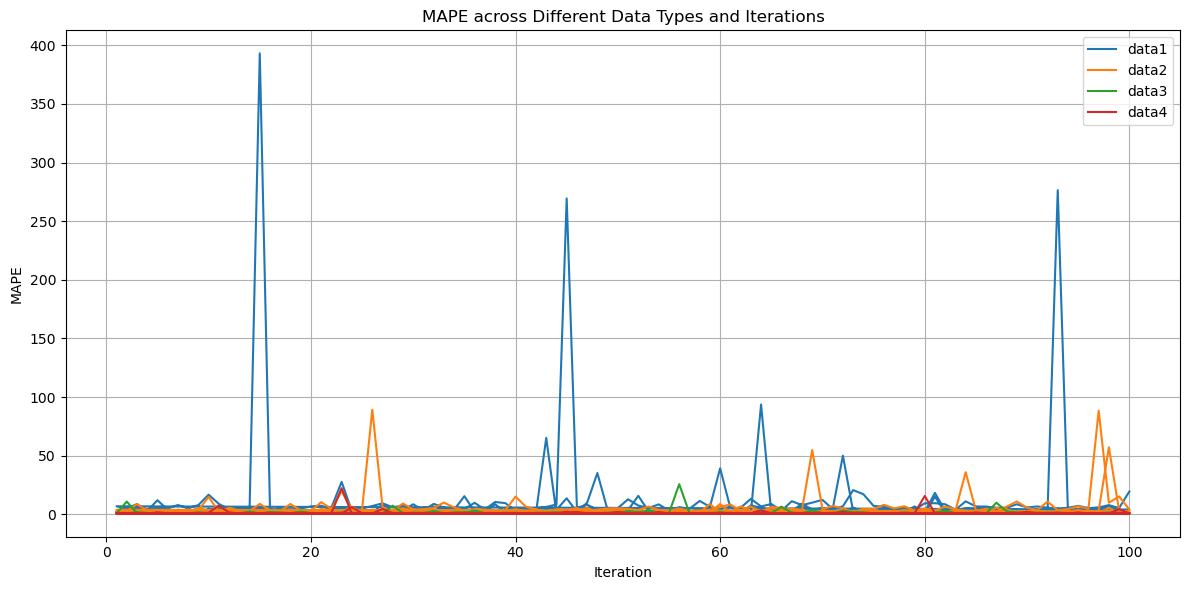

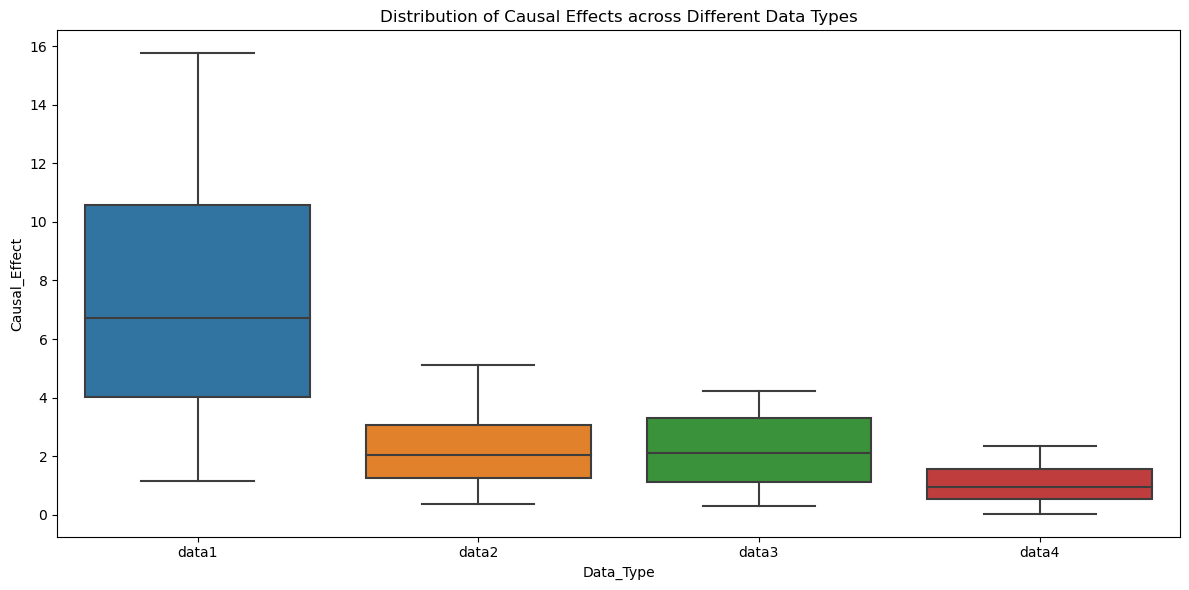

/var/folders/0x/n51_7s_n09dfndljqk4rv2zr0000gn/T/ipykernel_32335/3401261458.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=results_df, x='Sample_Size', y='MAPE', estimator=np.mean, ci='sd')


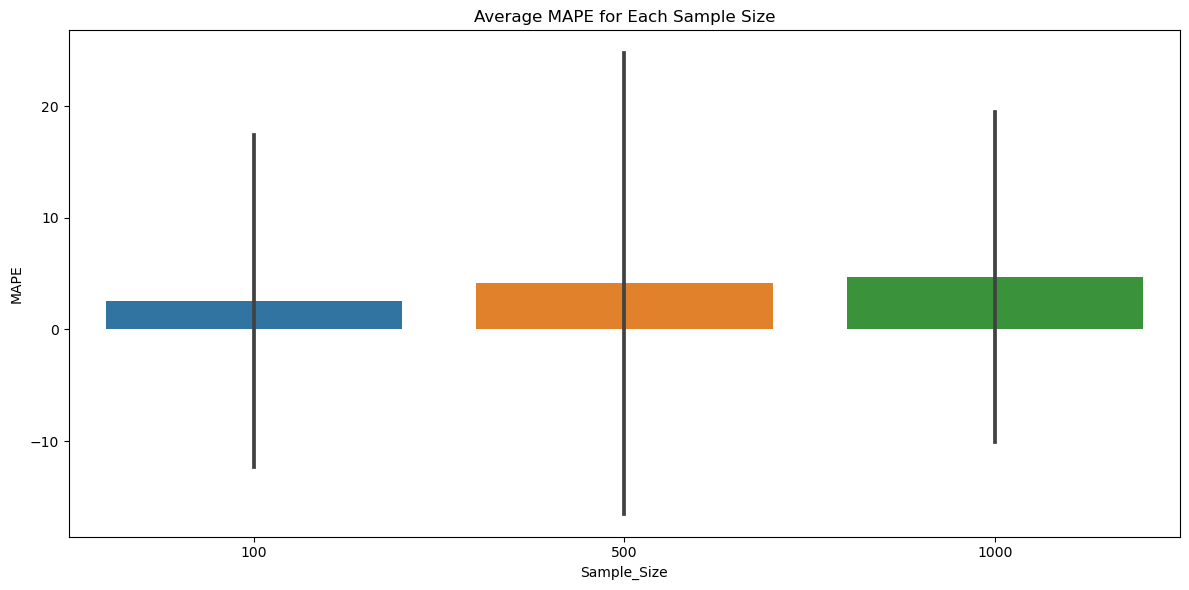

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. MAPE across Different Data Types and Iterations
plt.figure(figsize=(12, 6))
for dtype in results_df['Data_Type'].unique():
    subset = results_df[results_df['Data_Type'] == dtype]
    plt.plot(subset['Iteration'], subset['MAPE'], label=dtype)

plt.title('MAPE across Different Data Types and Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribution of Causal Effects
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Data_Type', y='Causal_Effect')
plt.title('Distribution of Causal Effects across Different Data Types')
plt.tight_layout()
plt.show()

# 3. Average MAPE for Each Sample Size
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Sample_Size', y='MAPE', estimator=np.mean, ci='sd')
plt.title('Average MAPE for Each Sample Size')
plt.tight_layout()
plt.show()
